## Percentile Confidence Interval Calculator
This Python script calculates the 95% confidence interval for a specified percentile (e.g., the 70th percentile) of a dataset. The confidence interval provides a range in which we expect the true percentile value to lie with 95% confidence.

The calculation makes use of the binomial distribution properties, making an assumption that our data can be modeled by a binomial distribution. This assumption may not always be accurate, especially for continuous data, but it provides an approximation for our purposes.

#### Assumptions
1. Binary Outcome: The fundamental assumption behind the binomial distribution is that there is a binary outcome, often termed as 'success' and 'failure'. In the context of percentiles, you can think of 'success' as the instances below the percentile and 'failure' as the instances above.


2. Fixed Number of Trials: For the binomial distribution, there is a fixed number n of trials. In our case, n represents the total number of data points in our sample.


3. Independence: Each trial (or data point) is independent of others. This means the outcome of one trial does not affect the outcome of another.


4. Constant Probability of Success: The probability of success, q, is the same for each trial. Here, q represents the percentile value. For example, for the 70th percentile, q=0.7.

#### Why the Binomial Distribution?
The rationale behind using the binomial distribution for percentile confidence intervals is its direct applicability to cases where you're looking at the proportion of observations below a certain threshold (i.e., a percentile).

When you're asking about the 70th percentile, you're essentially inquiring: "What's the value below which 70% of my data falls?" This can be likened to asking about the number of successes in n trials, where a success is an observation below the desired threshold.

However, it's important to note that this method provides an approximation. The binomial distribution is discrete and inherently based on counting successes in a set number of trials, while percentiles often come from continuous distributions and may not perfectly adhere to the assumptions above.

In [29]:
import numpy as np
from scipy.stats import binom
import seaborn as sns

#### Get some data

In [30]:
# Load the Iris dataset
iris = sns.load_dataset("iris")
# Use the 'sepal_length' feature
data = iris['sepal_length'].values

print(data[:50])

[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5. ]


#### Calculate the 70th percentile

In [31]:
# Calculate the 70th percentile
percentile_70 = np.percentile(data, 70)
print("Min: %f, Max: %f, 70th percentile: %f" % (min(data), max(data), percentile_70))

Min: 4.300000, Max: 7.900000, 70th percentile: 6.300000


#### Convert the data to "success" (above the 70th percentile) and "failure"

In [32]:
successes = np.sum(data > percentile_70)
failures = len(data) - successes

# Now, `successes` is analogous to `q * n` in the binomial scenario.
# So, we can set:
n = len(data)
q = successes / n

print("n: %d, q: %f" % (n, q))

n: 150, q: 0.280000


#### Calculate the 95% confidence interval
The code calculates potential upper (u) and lower (l) bounds for a confidence interval using the binomial distribution's percent-point function (ppf).

**np.ceil(binom.ppf(1 - alpha / 2, n, q))** determines the approximate upper bound for the confidence interval and **np.ceil(binom.ppf(alpha / 2, n, q))** for the lower bound.

**+ np.arange(-2, 3)** extends these bounds by adding an array of [-2, -1, 0, 1, 2], generating a set of potential boundaries around the original estimate.

**u** gives a sequence of indices in the dataset that demarcate the upper bound of the confidence interval. It starts from the calculated index for the 97.5th percentile and provides two more indices above and two below it.

**l** gives a sequence of indices in the dataset that demarcate the lower bound of the confidence interval. It starts from the calculated index for the 2.5th percentile and provides two more indices above and two below it.

In [33]:
alpha = 0.05
u = np.ceil(binom.ppf(1 - alpha / 2, n, q)) + np.arange(-2, 3)
u[u > n] = np.inf

l = np.ceil(binom.ppf(alpha / 2, n, q)) + np.arange(-2, 3)
l[l < 0] = -np.inf

print("u: " + ", ".join(map(str, u)))
print("l: " + ", ".join(map(str, l)))

u: 51.0, 52.0, 53.0, 54.0, 55.0
l: 29.0, 30.0, 31.0, 32.0, 33.0


In [35]:
sorted_data = np.sort(data)

# Extract values corresponding to the indices
# Correct way to interpret the u and l values
u_values = sorted_data[n - u.astype(int)]
l_values = sorted_data[l.astype(int) - 1]

print("Upper values:", u_values)
print("Lower values:", l_values)

Upper values: [6.3 6.2 6.2 6.2 6.2]
Lower values: [5.  5.  5.  5.  5.1]


#### Probability coverage
The code calculates the probability coverage of different combinations of potential confidence intervals formed by the lower bounds **(l)** and upper bounds **(u)**. **Coverage** is a matrix of probabilities. The goal is to find the smallest confidence interval that guarantees coverage of at least **1−α**.

In [42]:
coverage = np.zeros((len(l), len(u)))
for i, a in enumerate(l):
    for j, b in enumerate(u):
        coverage[i, j] = binom.cdf(b - 1, n, q) - binom.cdf(a - 1, n, q)

if np.max(coverage) < 1 - alpha:
    i = np.where(coverage == np.max(coverage))
else:
    i = np.where(coverage == np.min(coverage[coverage >= 1 - alpha]))

print("Coverage Matrix:")
print(coverage)

print("\nOptimal Indices (i_l, i_u):")
print(i)

Coverage Matrix:
[[0.93135214 0.95028522 0.96430299 0.97438285 0.98142424]
 [0.92730647 0.94623955 0.96025732 0.97033718 0.97737857]
 [0.92096076 0.93989385 0.95391161 0.96399148 0.97103286]
 [0.91140808 0.93034117 0.94435894 0.9544388  0.96148018]
 [0.89759319 0.91652627 0.93054404 0.9406239  0.94766529]]

Optimal Indices (i_l, i_u):
(array([0], dtype=int64), array([1], dtype=int64))


In [45]:
i_l = i[0][0]
i_u = i[1][0]
print("Chosen row of coverage matrix: %d, chosen column of coverage matrix: %d" % (i_l, i_u))

u_final = min(n, u[i_u])
u_final = max(0, int(u_final)-1)
        
l_final = min(n, l[i_l])
l_final = max(0, int(l_final)-1)

# Actual value corresponding to u_final and l_final
upper_value_threshold = n - u_final
lower_value_threshold = l_final

upper_value = sorted_data[upper_value_threshold]
lower_value = sorted_data[lower_value_threshold]

print("Lower bound value:", lower_value)
print("Upper bound value:", upper_value)

Chosen row of coverage matrix: 0, chosen column of coverage matrix: 1
Lower bound value: 5.0
Upper bound value: 6.3


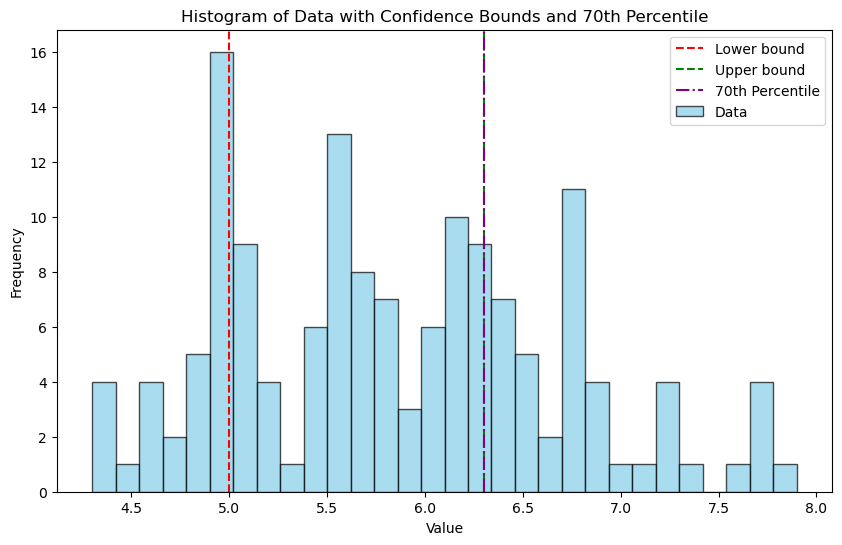

In [47]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Data')

# Adding vertical lines for lower_value and upper_value
plt.axvline(lower_value, color='red', linestyle='--', label='Lower bound')
plt.axvline(upper_value, color='green', linestyle='--', label='Upper bound')

# Adding vertical line for the 70th percentile
plt.axvline(percentile_70, color='purple', linestyle='-.', label='70th Percentile')

# Adding title and labels
plt.title('Histogram of Data with Confidence Bounds and 70th Percentile')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

#### Bootstrap method
A commonly used alternative method to calculate confidence intervals for percentiles (also known as quantiles) is the **Bootstrap method**.

The Bootstrap method involves resampling the dataset multiple times with replacement and then computing the desired statistic (in this case, the 70th percentile) for each of these resampled datasets. This gives a distribution of the 70th percentiles from which we can compute the confidence interval.

**lower**: This represents the value below which the bottom 2.5% of your jotted down 70th percentiles fall. In other words, it's like saying, "In 2.5% of our bootstrap 'experiments,' the 70th percentile was below this value."

**upper**: This is the value below which the bottom 97.5% of your jotted down 70th percentiles fall. Put another way, "In 97.5% of our bootstrap 'experiments,' the 70th percentile was below this value."

In [48]:
import numpy as np

def bootstrap_percentile_CI(data, percentile=70, alpha=0.05, B=10000):
    """Calculate the bootstrap confidence interval for a given percentile."""
    n = len(data)
    resampled_percentiles = []

    for _ in range(B):
        resample = np.random.choice(data, n, replace=True)
        resampled_percentiles.append(np.percentile(resample, percentile))

    lower = np.percentile(resampled_percentiles, 100 * alpha/2)
    upper = np.percentile(resampled_percentiles, 100 * (1-alpha/2))
    
    return lower, upper

# Calculate the bootstrap 70th percentile confidence interval
lower_bootstrap, upper_bootstrap = bootstrap_percentile_CI(data)
print("Bootstrap 70th percentile CI: (%.2f, %.2f)" % (lower_bootstrap, upper_bootstrap))

Bootstrap 70th percentile CI: (6.10, 6.43)


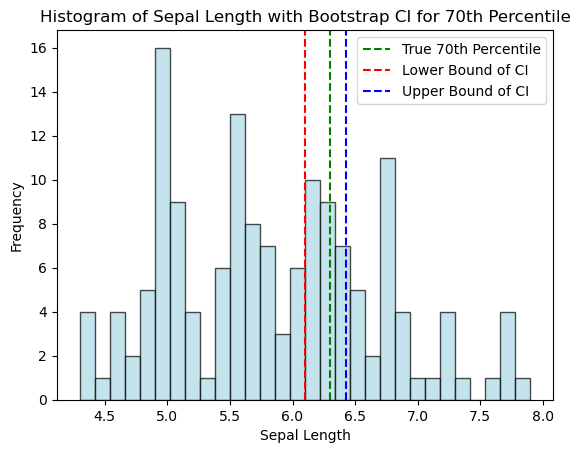

In [49]:
# Plotting
plt.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.percentile(data, 70), color='green', linestyle='--', label="True 70th Percentile")
plt.axvline(x=lower_bootstrap, color='red', linestyle='--', label="Lower Bound of CI")
plt.axvline(x=upper_bootstrap, color='blue', linestyle='--', label="Upper Bound of CI")
plt.legend()
plt.title('Histogram of Sepal Length with Bootstrap CI for 70th Percentile')
plt.xlabel('Sepal Length')
plt.ylabel('Frequency')
plt.show()

#### Discussion
The bootstrap method makes minimal assumptions about the distribution of the data, making it versatile for a wide variety of datasets. This flexibility allows the bootstrap to handle complex or unknown data distributions, whereas the binomial method assumes data follows a binomial distribution and is mainly suited for binary outcomes. While the binomial approach is computationally simpler and quicker, it might not always provide an accurate representation, especially if the underlying assumptions aren't met. In contrast, the bootstrap can be more computationally intensive due to resampling but offers the advantage of being more adaptable and often provides a more accurate estimate for datasets that don't strictly adhere to a binomial distribution.